# 8.3 Lab: Decision Trees

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn import tree
import matplotlib.pyplot as plt

%matplotlib inline

## 8.3.1 Fitting Classification Trees

In [3]:
""" 
The sklearn library has a lot of useful tools for tress. We first use classification trees to analyze the Carseats data set.
In these data, Sales is a continuous variable, and so we begin by recoding it as a binary variable (by thresholding). 
We use the map() function to create a variable, called High, which takes on a value of 'Y' if the Sales variable exceeds 8, 
and takes on a value of 'N' otherwise. In Python, we need to code catergorical variable into dummy variable.
"""

carseats = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Carseats.csv')
carseats['High'] = carseats.Sales.map(lambda x: 'Y' if x>8 else 'N')
carseats.ShelveLoc = pd.factorize(carseats.ShelveLoc)[0]
carseats.Urban = carseats.Urban.map({'No':0, 'Yes':1})
carseats.US = carseats.US.map({'No':0, 'Yes':1})
print(carseats.describe())
print(carseats.info())

            Sales   CompPrice      Income  Advertising  Population  \
count  400.000000  400.000000  400.000000   400.000000  400.000000   
mean     7.496325  124.975000   68.657500     6.635000  264.840000   
std      2.824115   15.334512   27.986037     6.650364  147.376436   
min      0.000000   77.000000   21.000000     0.000000   10.000000   
25%      5.390000  115.000000   42.750000     0.000000  139.000000   
50%      7.490000  125.000000   69.000000     5.000000  272.000000   
75%      9.320000  135.000000   91.000000    12.000000  398.500000   
max     16.270000  175.000000  120.000000    29.000000  509.000000   

            Price   ShelveLoc         Age   Education       Urban          US  
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000  
mean   115.795000    1.307500   53.322500   13.900000    0.705000    0.645000  
std     23.676664    0.833475   16.200297    2.620528    0.456614    0.479113  
min     24.000000    0.000000   25.000000   10.00

In [4]:
# we first split the dataset into training (200 samples) and test sets.
X = carseats.drop(['Sales', 'High'], axis=1)
y = carseats.High
train_size = 200
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, 
                                    test_size=X.shape[0]-train_size, random_state=0)

In [5]:
# to build a tree, we could use 'gini' or 'entropy' as split criterion at each node. 
# here we use an example use 'gini' and with a few other hyperparameters.
criteria = "gini" 
max_depth = 6 
min_sample_leaf = 4
clf_gini = DecisionTreeClassifier(criterion=criteria, random_state=100,
                                max_depth=max_depth, min_samples_leaf=min_sample_leaf)
clf_gini.fit(X_train, y_train)
print(clf_gini.score(X_train, y_train))


0.9


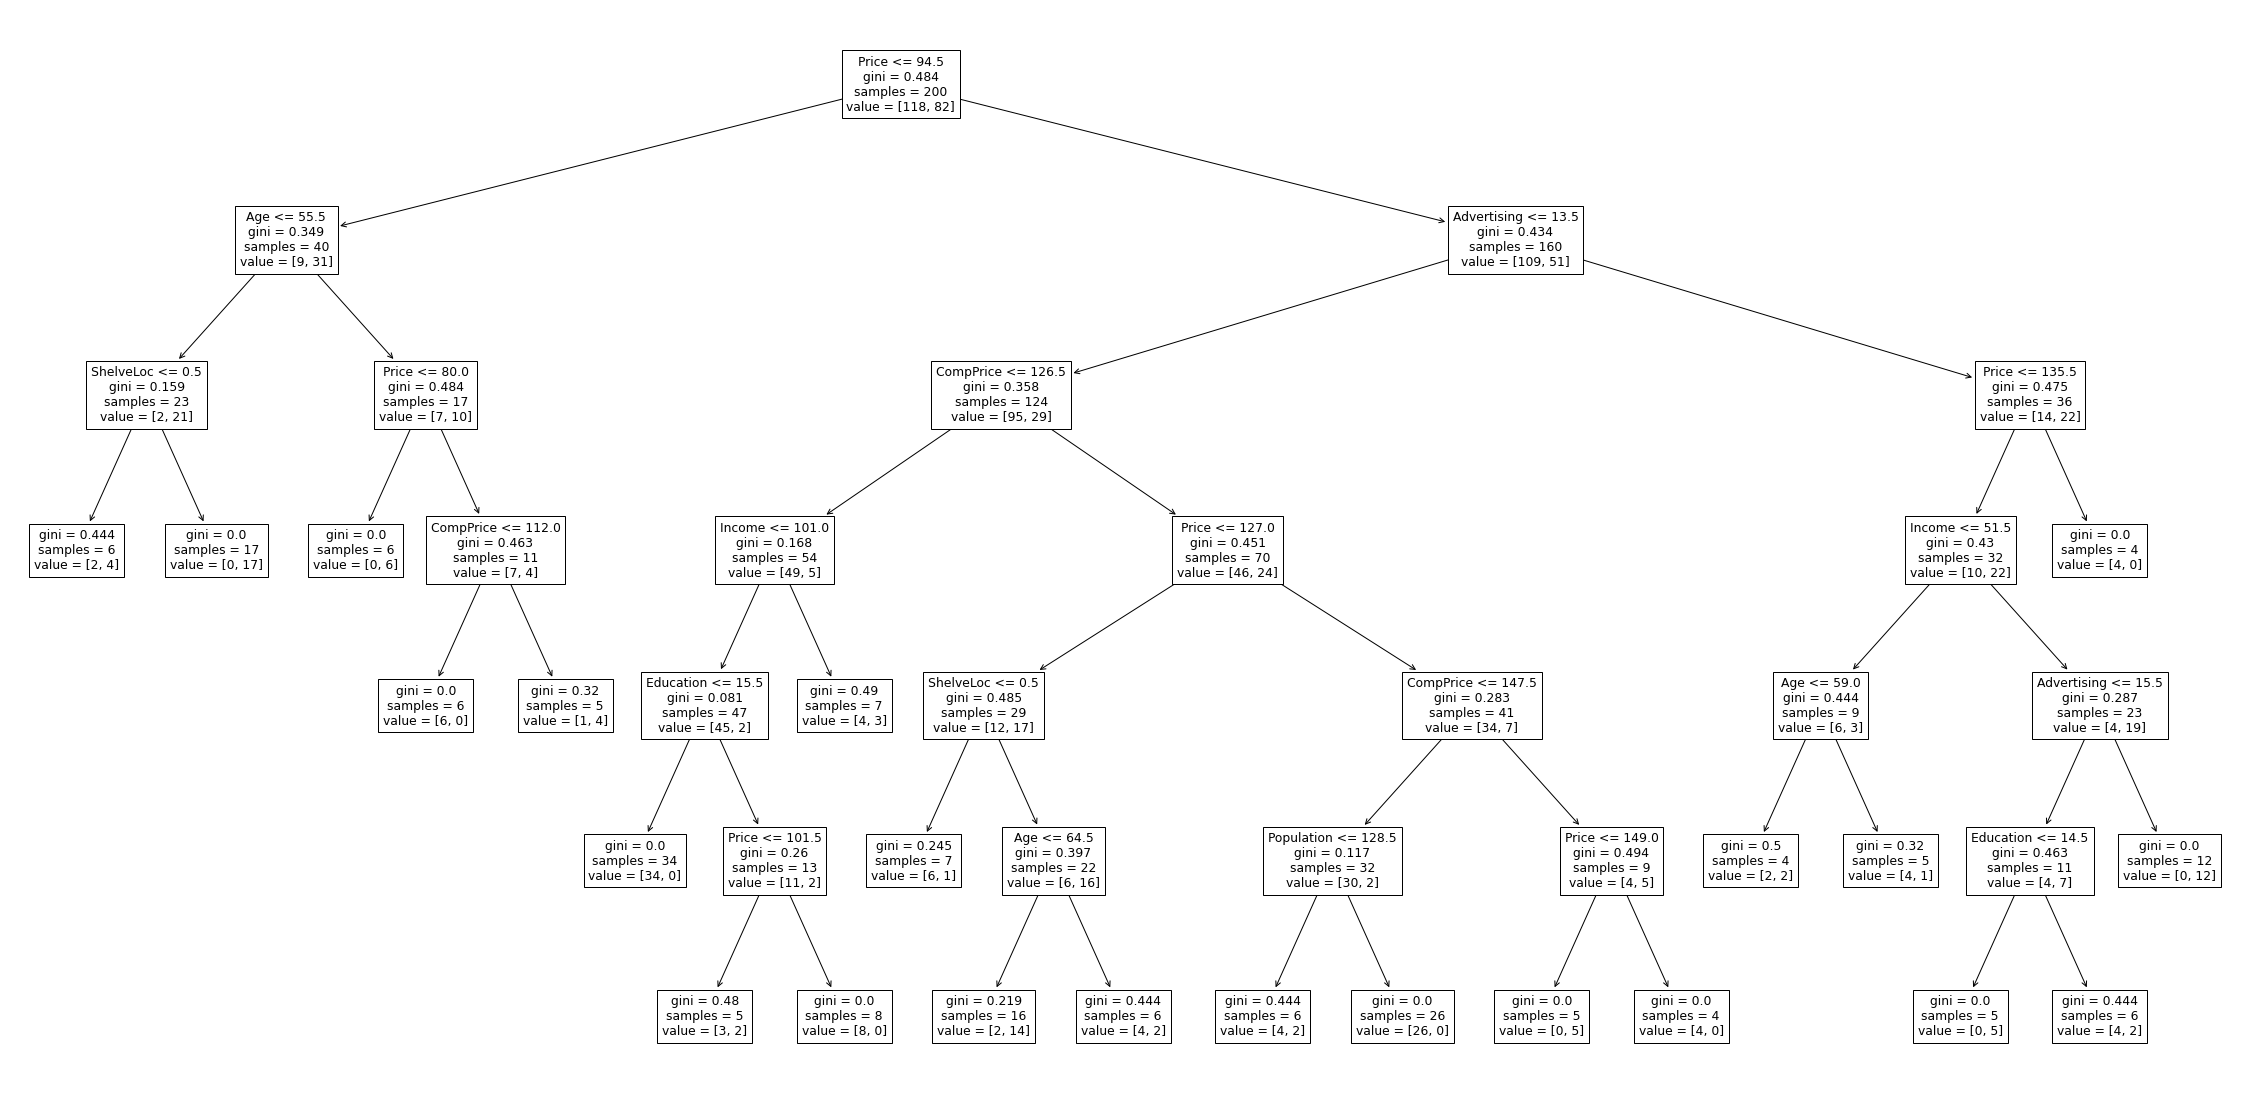

In [6]:
# one attractive feature of a tree is visulization. 
plt.figure(figsize=(40,20))  # customize according to the size of your tree
plot_tree(clf_gini, feature_names = X_train.columns)
plt.show()


In [7]:
# let us build the confusion matrix to evaluate the model in accuracy for both training and test datasets.
# we could also compute more metrics such as precision, recall, f1-score, etc.
y_pred_train = clf_gini.predict(X_train)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred_train).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)
print("Train Accuracy is ", accuracy_score(y_train,y_pred_train)*100)


y_pred = clf_gini.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)
print("Test Accuracy is ", accuracy_score(y_test,y_pred)*100)

"""
The test accuracy of our model is significant lower than our training result, this may indicate overfitting. 
we can go back and change the hyperparameters in the training process to reduce the dimension of the parameter space.
"""

      No  Yes
No   113   15
Yes    5   67
Train Accuracy is  90.0
     No  Yes
No   99   32
Yes  19   50
Test Accuracy is  74.5


'\nThe test accuracy of our model is significant lower than our training result, this may indicate overfitting. \nwe can go back and change the hyperparameters in the training process to reduce the dimension of the parameter space.\n'

## 8.3.2 Fitting Regression Trees

In [8]:
""" 
Another attractive feature of a tree is the ability to solve both classification and regression problems.
Here we fit a regression tree to the Boston data set. First, we create a training set, and fit the tree to the training data. 
Since Python does not support back-prune, let us use the max_depth at 2.
"""

# as we move forward, it is good to keep the hyperparameters together for future iterations.
boston = pd.read_csv('./data/Boston.csv')
X = boston.drop('medv', axis=1)
y = boston.medv
train_size = 0.5 # we used specific train size before, we can also use a percentage. 
random_state = 0 
max_depth = 2

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
regr_tree = DecisionTreeRegressor(max_depth=max_depth)
regr_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

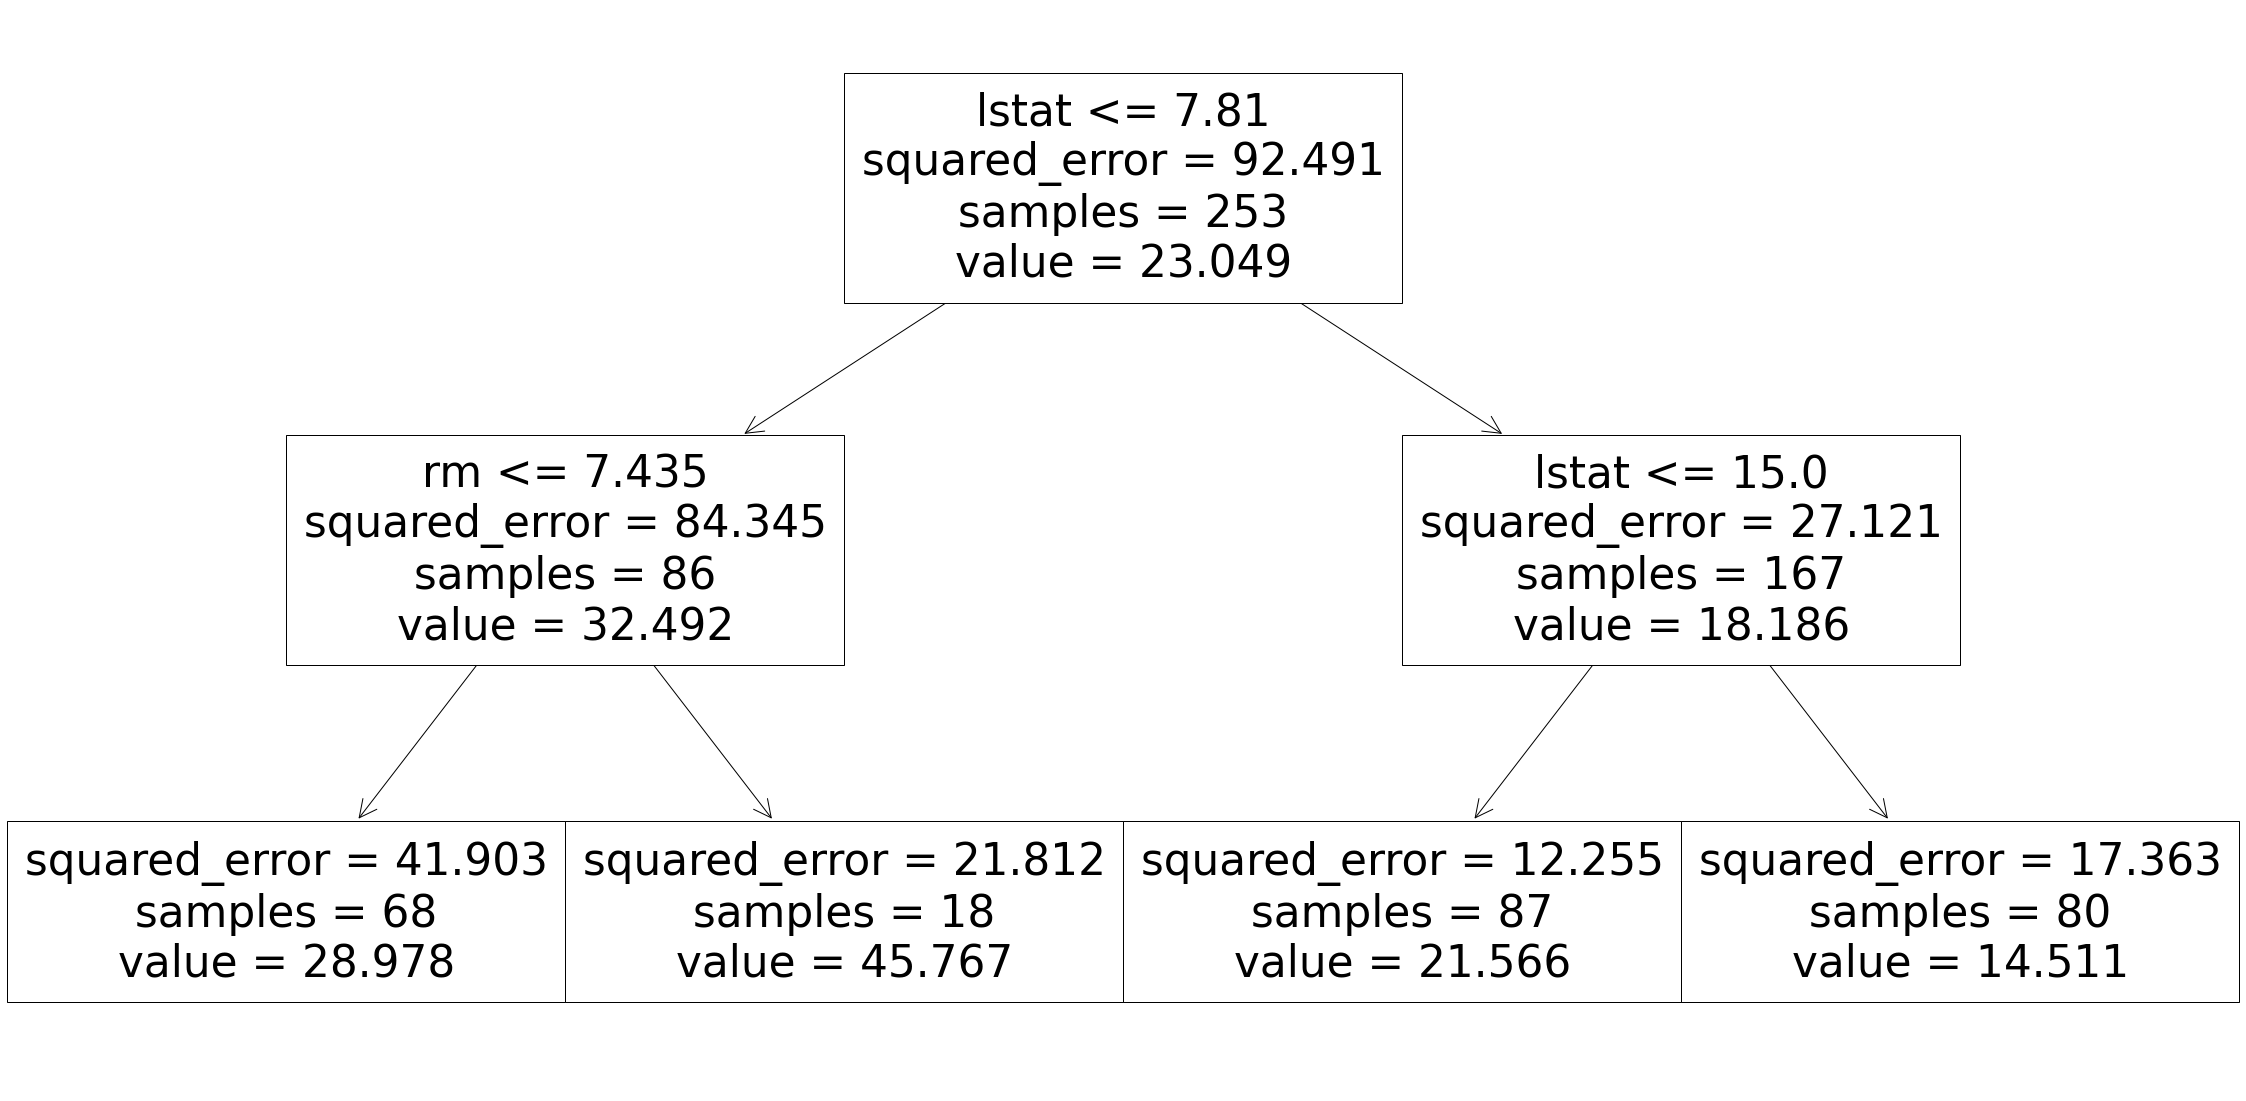

In [9]:
plt.figure(figsize=(40,20))  # customize according to the size of your tree
plot_tree(regr_tree, feature_names = X_train.columns)
plt.show()

In [10]:
y_pred = regr_tree.predict(X_test)
print(mean_squared_error(y_test, y_pred))
""" 
We could look more into train and test accuracy to see whether the current model is overfitting or underfitting.
"""

28.801544864457952


' \nWe could look more into train and test accuracy to see whether the current model is overfitting or underfitting.\n'

## 8.3.3 Bagging and Random Forests

In [11]:
"""
Here we apply bagging and random forests (RF) to the Boston data.
RF is an ensemble method, which means it combines the results of multiple decision trees. 
As a result, RF could help to reduce the variance of the model. 
Similar to decision trees, RF can be used to solve both classification and regression problems.


In this excercise, we will use the randomForest package in Python. 
The exact results obtained in this section may depend on the version of Python and the version of the randomForest package installed on your computer. 
"""

'\nHere we apply bagging and random forests (RF) to the Boston data.\nRF is an ensemble method, which means it combines the results of multiple decision trees. \nAs a result, RF could help to reduce the variance of the model. \nSimilar to decision trees, RF can be used to solve both classification and regression problems.\n\n\nIn this excercise, we will use the randomForest package in Python. \nThe exact results obtained in this section may depend on the version of Python and the version of the randomForest package installed on your computer. \n'

In [12]:
# we reused the previous train and test sets.
all_features = X_train.shape[1]
regr_bagging = RandomForestRegressor(max_features=all_features, random_state=1)
regr_bagging.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

In [13]:
y_pred = regr_bagging.predict(X_test)
print(mean_squared_error(y_test, y_pred))

"""
we can compare the test accuracy of the bagging model with the test accuracy of the singl regression tree above.
Normally, the bagging model is better than the single tree model.
"""

16.17512869960475


'\nwe can compare the test accuracy of the bagging model with the test accuracy of the singl regression tree above.\nNormally, the bagging model is better than the single tree model.\n'

In [14]:
"""
We can grow a random forest in exactly the same way, except that we'll use a smaller value of the max_features argument. 
Theoretically, radomly selecting a subset of features could reduce the correlation of the tress and can reduce the variance of the model.
"""
# here we'll use max_features = 3 (close to square root of all features as a rule of thumb)
regr_rf = RandomForestRegressor(max_features=3, random_state=1)
regr_rf.fit(X_train, y_train)

y_pred = regr_rf.predict(X_test)
print(mean_squared_error(y_test, y_pred))

""" 
The test set MSE is even lower; this indicates that random forests yielded an improvement over bagging in this case.
"""

15.38572678260869


' \nThe test set MSE is even lower; this indicates that random forests yielded an improvement over bagging in this case.\n'

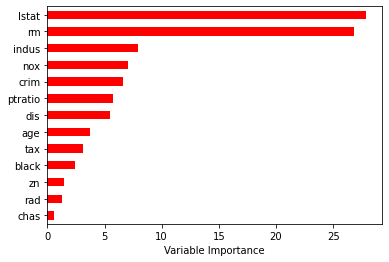

In [15]:
# RF provides multiple ways to interpret the model. One way is to see the importance of each feature.
Importance = pd.DataFrame({'Importance':regr_rf.feature_importances_*100}, index=X_train.columns)
Importance.sort_values(by='Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 8.3.4 Boosting

Here we use the GradientBoostingRegressor package. The argument n_estimators=500 indicates that we want 500 trees, and the option interaction.depth=4 limits the depth of each tree.

In [16]:
"""
Boosting is another ensemble method. Gradient Boosting is a popular method, 
and other well-known methods include AdaBoost, XGBoost, and LightGBM are buiit on top of it.

Here we use the GradientBoostingRegressor package. The argument n_estimators=500 indicates that we want 500 trees, 
and the option interaction.depth=4 limits the depth of each tree. See the manuel for more details.
"""

regr_boost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.02, max_depth=4, random_state=1)
regr_boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=500,
                          random_state=1)

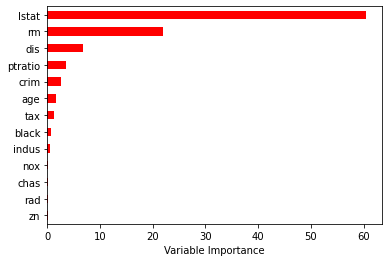

In [17]:
# let us check the feature importance and MSE.
feature_importance = regr_boost.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X_train.columns).sort_values(inplace=False)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [18]:
y_pred = regr_boost.predict(X_test)
print(mean_squared_error(y_test,y_pred))

16.99803803771022


## 8.3.5 Bayesian Additive Regression Trees
As of now (2021), I was not able to find a good package for BART in Python. Please reach out if you have a package that works.
** [To do: find a package for BART in Python.] **

In [19]:
"""
Here we discuss Bayesian additive regression trees (BART), another ensemble method that uses decision trees as its building blocks.
BART is related to both Random forest and boosting: each tree is constructed in a random manner as in bagging and random forests, 
and each tree tries to capture signal not yet accounted for by the current model, as in boosting. 
The main novelty in BART is the way in which new trees are generated.
"""

'\nHere we discuss Bayesian additive regression trees (BART), another ensemble method that uses decision trees as its building blocks.\nBART is related to both Random forest and boosting: each tree is constructed in a random manner as in bagging and random forests, \nand each tree tries to capture signal not yet accounted for by the current model, as in boosting. \nThe main novelty in BART is the way in which new trees are generated.\n'

In [20]:
# End of Chapter 8